In [23]:
import tequila as tq
import numpy as np
import cirq
import matplotlib.pyplot as plt

In [41]:
geometry = """
H 0.0 0.0 0.0
H 0.0 0.0 1.5
H 0.0 0.0 3.0
H 0.0 0.0 4.5
"""

# Make a molecule based on the given geometry and basis set. The transformation will transform from fermionic to spin hamiltonian
mol = tq.Molecule(geometry=geometry, basis_set="sto-3g", transformation="ReorderedJordanWigner")

H = mol.make_hamiltonian()
v = np.linalg.eigvalsh(H.to_matrix())

# Pairing model Hamiltonian in molecular basis (what is the molecular basis?)
HCB1 = mol.make_hardcore_boson_hamiltonian()

In [43]:
# Ground State (What are the edges here?)
U1HCB = mol.make_ansatz(name="HCB-SPA", edges=[(0,1),(2, 3)], label=1)

E1 = tq.ExpectationValue(H=HCB1, U=U1HCB)
result = tq.minimize(E1, silent=True)

# fix variables (no need to change them anymore)
U1HCB = U1HCB.map_variables(variables=result.variables)

gs_energy = result.energy
gs_energy

-1.5561260779839987

In [ ]:
# Excited State
U2HCB = mol.make_ansatz(name="HCB-SPA", edges=[(0,1), (2, 3)], label=2)

# Pairing model Hamiltonian in atomic basis
HCB2 = mol.use_native_orbitals().make_hardcore_boson_hamiltonian()
E2 = tq.ExpectationValue(H=HCB2, U=U2HCB)

# ????? What bases are we rotating between ?????
# Rotation between the bases
var = (tq.Variable("R0") + 0.5) * np.pi
# var = 0.16979011865491328
UR = mol.UR(0,1,var) + mol.UR(2,3,var) + mol.UR(1,2,var)

# ????? Why do we need to change back to fermions ?????
# change from pairing model (hardcore-bosons) back to fermions
UF = mol.hcb_to_me()

# Overlap between the states
P0 = tq.paulis.Projector(wfn="|00000000>")
S = tq.ExpectationValue(H=P0, U=U1HCB + UF + UR + UF.dagger() + U2HCB.dagger())

res = tq.minimize(S, silent=True)

In [89]:
res.variables

{R0: -6.285900835224e-14, ((2, 3), 'D', 2): -1.5747757449978184, ((0, 1), 'D', 2): -1.5747757449978217}

In [90]:
# excited state objective
objective = E2 - gs_energy*S
result2 = tq.minimize(objective, silent = True)
ex_energy = result2.energy

In [91]:
print("energies and errors")
print("gs energy: {:+2.5f} | {:2.5f}".format(gs_energy, gs_energy-v[0]))

# for a bond distance of 1.0, state number 8 (so energy v[8]) is the one we are after
# for others it might change, so I just find the closest eigenenergy approximated
errors = [abs(ex_energy - e) for e in v]
print("ex energy: {:+2.5f} | {:2.5f}".format(ex_energy, min(errors)))

# let's compute the overlap (should be zero after optimization)
overlap = tq.simulate(S, variables=result2.variables)
print("overlap  : {:2.9f}".format(overlap))

energies and errors
gs energy: -1.55613 | 0.44002
ex energy: -0.81314 | 0.00676
overlap  : 0.042578709


In [83]:
#E and E2 are just energy calculations analog to H4 (same model, basically the same 2-qubit circuit)
#S is the overlap between the two states
#as the two states live in different models, this needs to be incorporated
#UF transforms to Fermions and UR rotates the orbitals
print("Info on the Overlap Objective")
print(S)
# get the circuit (only one expectation value in the objective)
U = S.get_expectationvalues()[0].U
# compile all gates, but stop at "exponential-pauli" level
# here we only have 2-Paulis as generators
# the circuit will have: CNOTS, Ry, and XY-gates with fixed angle (since I can guess the orbital basis here without optimizing)
# the circuit just has 1 variable, so explicit optimization might be feasible
U = tq.compile_circuit(U, exponential_pauli=False)
# circuit as pretty picture (needs qpic installed | will send it with email as well)
try:
    U.export_to(filename="overlap_circuit.pdf")
except Exception as E:
    print("no qpic and/or latex installed ... sorry")

Info on the Overlap Objective
Objective with 1 unique expectation values
total measurements = 1
variables          = [R0, ((2, 3), 'D', 2), ((0, 1), 'D', 2)]
types              = not compiled
tikz2preview overlap_circuit.tikz
pdflatex -interaction=batchmode overlap_circuit.tex
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode


# Simulate Circuit

In [59]:
S_cirq = tq.compile(S, backend="cirq")
S_circuit = S_cirq.get_expectationvalues()[0].U.circuit
S_circuit

┌────┐                                                                                             ┌────┐
0: ───X──────────X────@───────X───H──────────────────────────────────X──────────────────────────────────────X───H───X───────@────X───X────────────────────────────────────────────────
                 │    │       │                                      │                                      │       │       │    │
1: ───Y^-0.278───@────┼@──────@───Y^(0.318309886183791*f((R0,))_0)───@───Y^(0.318309886183791*f((R0,))_1)───@───────@──────@┼────@───Y^(0.318309886183791*f((((0, 1), 'D', 2),))_9)───
                      ││                                                                                                   ││
2: ───X──────────X────┼┼@─────X───H──────────────────────────────────X──────────────────────────────────────X───H───X─────@┼┼────X───X────────────────────────────────────────────────
                 │    │││     │                                      │                                      │       │     │││    │
3: ───Y^-0.21────@────┼┼┼@────@───Y^(0.318309886183791*f((R0,))_4)───@───Y^(0.318309886183791*f((R0,))_5)───@───────@────@┼┼┼────@───Y^(0.318309886183791*f((((2, 3), 'D', 2),))_8)───
                      ││││                                                                                               ││││
4: ───────────────────X┼┼┼────X───H──────────────────────────────────X──────────────────────────────────────X───H───X────┼┼┼X─────────────────────────────────────────────────────────
                       │││    │                                      │                                      │       │    │││
5: ────────────────────X┼┼────@───Y^(0.318309886183791*f((R0,))_2)───@───Y^(0.318309886183791*f((R0,))_3)───@───────@────┼┼X──────────────────────────────────────────────────────────
                        ││                                                                                               ││
6: ─────────────────────X┼────X───H──────────────────────────────────X──────────────────────────────────────X───H───X────┼X───────────────────────────────────────────────────────────
                         │    │                                      │                                      │       │    │
7: ──────────────────────X────@───Y^(0.318309886183791*f((R0,))_6)───@───Y^(0.318309886183791*f((R0,))_7)───@───────@────X────────────────────────────────────────────────────────────
                     └────┘                                                                                             └────┘

In [75]:
simulator = cirq.Simulator()

param_R0 = result.variables["R0"]
param_1 = result.variables[list(result.variables.keys())[1]]
param_2 = result.variables[list(result.variables.keys())[2]]

simulator = cirq.Simulator()

zero_state_populations = []
parameterized_angles = []

for parameterized_angle in range(1):

    new_ops = []

    for moment in S_circuit:
        for op in moment:

            # Check if gate is the parameterized Y power gate:
            if op.gate not in [cirq.CNOT, cirq.H, cirq.X, cirq.CZ]:

                # Check whether the gate angle is a string (or not a number) - these are the parameterized ones
                if type(op.gate.exponent) != float:
                    
                    # R0 parameterized gates
                    if "R0" in str(op.gate.exponent.args[1]):
                        new_angle = float(op.gate.exponent.args[0]) * param_R0
                        new_global_shift = op.gate.global_shift
                        new_qubit_num = op.qubits[0]
                        new_operation = cirq.YPowGate(exponent=new_angle, global_shift=new_global_shift).on(new_qubit_num)
                        new_ops.append(new_operation)
                    
                    # f(0,1) parameterized gates
                    elif "(0, 1)" in str(op.gate.exponent.args[1]):
                        new_angle = float(op.gate.exponent.args[0]) * param_1
                        new_global_shift = op.gate.global_shift
                        new_qubit_num = op.qubits[0]
                        new_operation = cirq.YPowGate(exponent=new_angle, global_shift=new_global_shift).on(new_qubit_num)
                        new_ops.append(new_operation)                    

                    # f(2, 3) parameterized gates
                    else:
                        print(op)

                        new_angle = float(op.gate.exponent.args[0]) * param_2
                        new_global_shift = op.gate.global_shift
                        new_qubit_num = op.qubits[0]
                        new_operation = cirq.YPowGate(exponent=new_angle, global_shift=new_global_shift).on(new_qubit_num)
                        new_ops.append(new_operation)                    
                else:
                    new_ops.append(op)

            else:
                new_ops.append(op)

    new_circuit_from_optimization = cirq.Circuit(new_ops)

    circuit_result = simulator.simulate(new_circuit_from_optimization)
    print(circuit_result)


    zero_state_populations.append((circuit_result.final_state_vector[0].real)**2)
    parameterized_angles.append(parameterized_angle * 0.01)

YPowGate(exponent=0.318309886183791*f((((2, 3), 'D', 2),))_8, global_shift=-0.5)(q(3))
measurements: (no measurements)

qubits: (cirq.LineQubit(1), cirq.LineQubit(0), cirq.LineQubit(4), cirq.LineQubit(5))
output vector: 0.905|0000⟩ - 0.425|1000⟩

qubits: (cirq.LineQubit(3), cirq.LineQubit(2), cirq.LineQubit(6), cirq.LineQubit(7))
output vector: 0.945|0000⟩ - 0.327|1000⟩

phase:
output vector: |⟩


In [71]:
new_circuit_from_optimization

┌────┐                                           ┌────┐
0: ───X──────────X────@───────X───H─────────X─────────────X───H───X───────@────X───X──────────
                 │    │       │             │             │       │       │    │
1: ───Y^-0.278───@────┼@──────@───Y^0.054───@───Y^0.054───@───────@──────@┼────@───Y^-0.002───
                      ││                                                 ││
2: ───X──────────X────┼┼@─────X───H─────────X─────────────X───H───X─────@┼┼────X───X──────────
                 │    │││     │             │             │       │     │││    │
3: ───Y^-0.21────@────┼┼┼@────@───Y^0.054───@───Y^0.054───@───────@────@┼┼┼────@───Y^-0.002───
                      ││││                                             ││││
4: ───────────────────X┼┼┼────X───H─────────X─────────────X───H───X────┼┼┼X───────────────────
                       │││    │             │             │       │    │││
5: ────────────────────X┼┼────@───Y^0.054───@───Y^0.054───@───────@────┼┼X────────────────────
                        ││                                             ││
6: ─────────────────────X┼────X───H─────────X─────────────X───H───X────┼X─────────────────────
                         │    │             │             │       │    │
7: ──────────────────────X────@───Y^0.054───@───Y^0.054───@───────@────X──────────────────────
                     └────┘                                           └────┘

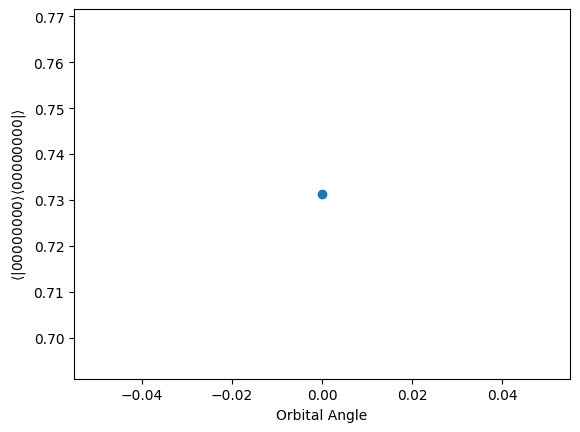

In [72]:
plt.scatter(parameterized_angles, zero_state_populations)
plt.xlabel("Orbital Angle")
plt.ylabel(r"$\langle |00000000 \rangle \langle 00000000| \rangle$")
plt.show()